In [1]:
import random
import numpy as np
import matplotlib
import time
from numba import jit
import multiprocessing as mp
from matplotlib import pyplot as plt

/Applications/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
@jit(nopython=True)
def demand(p1, p2):
    if p1 < p2:
        d = 1 - p1
    elif p1 == p2:
        d = 0.5 * (1 - p1)
    else:
        d = 0
    return d

In [3]:
@jit(nopython=True)
def profit(p1, p2):
    return (p1 * demand(p1, p2))

In [4]:
P = np.array([0, 1/6, 2/6, 3/6, 4/6, 5/6, 1]) # price array

# Epsilon greedy hjælpefunktion

In [9]:
np.random.seed(123)

@jit(nopython=True)
def epsilon_greedy(Qtable, epsilon, uniform, state: int, price_grid: np.ndarray) -> int: 
    N = len(price_grid)
    assert Qtable.shape[0] == N, "Qtable must have the same number of rows as there are prices in the grid"
    assert Qtable.shape[1] == N, "Qtable must have the same number of columns as there are prices in the grid"
    assert state < N, "state must be a valid index in the price grid"
    assert state >= 0, "state must be a valid index in the price grid"

    # Draw action 
    if uniform < epsilon:
        price_index = np.random.choice(N)
        #print("Random")
    else:
        price_index = np.argmax(Qtable[:, state])
        #print("Qtable")
    return price_index

# Q-learning and simulation function

In [6]:
np.random.seed(123)

@jit(nopython=True)
def Qfunction_test(price_grid, period, delta, alpha, theta):
    # Initialize prices and Q-tables
    price_index_i = np.random.choice(len(price_grid)) 
    price_index_j = np.random.choice(len(price_grid)) 

    Qtable_i = np.zeros((len(price_grid), len(price_grid)))
    Qtable_j = np.zeros((len(price_grid), len(price_grid)))

    profit_1 = np.zeros(int(period))
    profit_2 = np.zeros(int(period))

    total_profit = np.zeros(period)

    deviating = 0

    epsilons = (1 - theta)**np.arange(period + 1)
    uniforms = np.random.uniform(0, 1, (period + 1, 2))

    for t in range(1, period + 1):
        #epsilon = (1-theta)**t
        # figure out who's turn it is
        if t % 2 == 0:
            # player 2 is the responder
            # set up pointers to the state and the Q table 
            state = price_index_i # the most recent draw of player 1's price
            Qtable_i = Qtable_j
            Qtable_j = Qtable_i
            player_index = 1
            opponent_index = 0
        else:
            # player 1 is the responder
            state = price_index_j
            Qtable_i = Qtable_i
            Qtable_j = Qtable_j
            player_index = 0
            opponent_index = 1

        # current period 
        if price_index_i == 3 and state == 3 and t == 485001:
            print(profit(price_grid[price_index_i], price_grid[state]))
            price_index_i = 2
            print(profit(price_grid[price_index_i], price_grid[state]))
            deviating = 1


        decision = price_grid[price_index_i]
        state_i_responds_to = price_grid[state]
        profit_i_current_period = profit(decision, state_i_responds_to)

        # next period 
        state_next_period = price_index_i # next_period's state is today's price
        price_index_j_next_period = epsilon_greedy(Qtable_j, epsilons[t], uniforms[t, opponent_index], state=state_next_period, price_grid=price_grid)

        price_j_next_period = price_grid[price_index_j_next_period]

        

        price_i_next_period = price_grid[price_index_i] # unchanged price, it's not i's turn 
        profit_i_next_period = profit(price_i_next_period, price_j_next_period)

        max_Q = np.max(Qtable_i[:, price_index_j_next_period])
        continuation_value = max_Q 

        new_estimate = profit_i_current_period + delta * profit_i_next_period + delta**2 * continuation_value

        # Update
        prev_estimate = Qtable_i[price_index_i, price_index_j]
        Qtable_i[price_index_i, price_index_j] = (1 - alpha) * prev_estimate + alpha * new_estimate


         # Update for the next iteration: Use the simulated next period's action as the actual action for the opponent
        if t % 2 == 0:
        # If current period is Player 2's turn, update Player 1's price for the next period
            price_index_i = price_index_j_next_period
            profit_1[t-1] = profit(state_i_responds_to, decision)
            profit_2[t-1] = profit_i_current_period
        else:
        # If current period is Player 1's turn, update Player 2's price for the next period
            price_index_j = price_index_j_next_period
            profit_1[t-1] = profit_i_current_period
            profit_2[t-1] = profit(state_i_responds_to, decision)

        # Profit
        total_profit[t-1] = profit_i_current_period

    return total_profit, profit_1, profit_2, deviating


In [122]:
np.random.seed(123)

@jit(nopython=True)
def Qfunction(price_grid, period, delta, alpha, theta):
    # Initialize prices and Q-tables
    price_index_i = np.random.choice(len(price_grid)) 
    price_index_j = np.random.choice(len(price_grid)) 

    Qtable_i = np.zeros((len(price_grid), len(price_grid)))
    Qtable_j = np.zeros((len(price_grid), len(price_grid)))
    Qtable_temp = np.zeros((len(price_grid), len(price_grid)))

    profit_1 = np.zeros(int(period))
    profit_2 = np.zeros(int(period))

    total_profit = np.zeros(period)

    deviating = 0

    epsilons = (1 - theta)**np.arange(period + 1)
    uniforms = np.random.uniform(0, 1, (period + 1, 2))

    for t in range(1, period + 1):
        state = price_index_j # the most recent draw of player i's price

        # figure out who's turn it is
        if t % 2 == 0:
            # player 2 is the responder
            opponent_index = 0
        else:
            # player 1 is the responder
            opponent_index = 1
        
        #if price_index_i == 3 and price_index_j == 3 and state == 3 and t == 485001:
       
        
        # current period 
        decision = price_grid[price_index_i]
        state_i_responds_to = price_grid[state]
        profit_i_current_period = profit(decision, state_i_responds_to)

        # next period 
        state_next_period = price_index_i # next_period's state is today's price
        price_index_j_next_period = epsilon_greedy(Qtable_j, epsilons[t], uniforms[t, opponent_index], state=state_next_period, price_grid=price_grid)

        price_j_next_period = price_grid[price_index_j_next_period]
        price_i_next_period = price_grid[price_index_i] # unchanged price, it's not i's turn 
        profit_i_next_period = profit(price_i_next_period, price_j_next_period)

        max_Q = np.max(Qtable_i[:, price_index_j_next_period])
        continuation_value = max_Q 

        new_estimate = profit_i_current_period + delta * profit_i_next_period + delta**2 * continuation_value

        # Update
        prev_estimate = Qtable_i[price_index_i, state]

        # Update Q-table for player i
        Qtable_i[price_index_i, state] = (1 - alpha) * prev_estimate + alpha * new_estimate
        
        # Profit opponent 
        profit_opponent = profit(state_i_responds_to, decision)
        
        # Profit
        total_profit[t-1] = (profit_i_current_period + profit_opponent) / 2


         # Update for the next iteration: Use the simulated next period's action as the actual action for the opponent
        if t % 2 == 0:
            profit_1[t-1] = profit_opponent
            profit_2[t-1] = profit_i_current_period
        else:
            profit_1[t-1] = profit_i_current_period
            profit_2[t-1] = profit_opponent
        

        Qtable_temp = Qtable_j
        Qtable_j = Qtable_i
        Qtable_i = Qtable_temp
        price_index_j = price_index_i
        price_index_i = price_index_j_next_period

        if profit_1[t] == 0.125 and profit_2[t-1] == 0.125 and t == 485001:
            #print(profit(price_grid[price_index_i], price_grid[state]))
            price_index_i = 2
            #print(profit(price_grid[price_index_i], price_grid[state]))
            deviating = 1

    return total_profit, profit_1, profit_2, deviating

In [123]:
#@jit(nopython=True)
def Simulations(sim, price, period, delta, alpha, theta):
    total_profit_sim = np.zeros((sim, period))
    profit_1_sim = np.zeros((sim, period))
    profit_2_sim = np.zeros((sim, period))
    avg_profit = np.zeros(sim)
    avg_profit_1 = np.zeros(sim)
    avg_profit_2 = np.zeros(sim)
    deviating_sim = np.zeros(sim)
    change_arr = np.zeros((1,25))
    change_arr2 = np.zeros((1,25))

    for i in range(sim):
        total_profit_array, profit_1_array, profit_2_array, deviating_array = Qfunction(price, period, delta, alpha, theta)
        total_profit_sim[i] = total_profit_array
        profit_1_sim[i] = profit_1_array
        profit_2_sim[i] = profit_2_array
        deviating_sim[i] = deviating_array
        avg_profit_1[i] = np.mean(profit_1_array[-1000:])
        avg_profit_2[i] = np.mean(profit_2_array[-1000:])
        avg_profit[i] = np.mean(total_profit_array[-1000:])

        if deviating_array == 1:
            change_arr = np.vstack((change_arr, profit_1_array[484991:485016:1]))
            change_arr2 = np.vstack((change_arr2, profit_2_array[484991:485016:1]))

    return total_profit_sim, avg_profit_1, avg_profit_2, profit_1_sim, profit_2_sim, deviating_sim, change_arr, change_arr2

# Time calculation for 1000 simulations

In [124]:
start_time  = time.time()

np.random.seed(123)
total_profit_plot, avg_profit_1_plot, avg_profit_2_plot, profit_total_1, profit_total_2, deviating, change_arr_1, change_arr_2 = Simulations(1000, P, 500000, 0.95, 0.3, 0.0137205)

end_time = time.time()

elapsed_time = end_time - start_time

print("Time taken to run 1000 simulations:", elapsed_time, "seconds")

Time taken to run 1000 simulations: 33.68209099769592 seconds


In [125]:
print(deviating)
for i in range(len(deviating)):
    if deviating[i] == 1:
        print(i)
print(change_arr_2.shape)
print(change_arr_1.shape)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [119]:
def moving_avg(fst_arr, snd_arr, window_size):

    moving_averages = []
    moving_averages2 = []
    i = 0
    while i < len(fst_arr) - window_size + 1:
    
        # Calculate the average of current window
        window_average = np.sum(fst_arr[
        i:i+window_size]) / window_size
        window_average2 = np.sum(snd_arr[
        i:i+window_size]) / window_size
        
        # Store the average of current
        # window in moving average list
        moving_averages.append(window_average)
        moving_averages2.append(window_average2)

        
        # Shift window to right by one position
        i += 1
    return moving_averages, moving_averages2

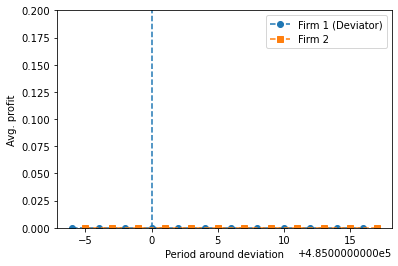

In [120]:
dev_arr = np.mean(change_arr_1, axis=0)
dev_arr2 = np.mean(change_arr_2, axis=0)

deviation_arr, deviation_arr2 = moving_avg(dev_arr, dev_arr2, 2)

deviation_t = np.arange(484994,485018, 2)
deviation_t2 = np.arange(484995,485019, 2)
deviation_arr = deviation_arr[0:24:2]
deviation_arr2 = deviation_arr2[1:25:2]
plt.plot(deviation_t, deviation_arr, '--o', label='Firm 1 (Deviator)')
plt.plot(deviation_t2, deviation_arr2, 's--', label='Firm 2')
plt.vlines(x=485000, ymin=0.00, ymax=0.2, linestyle = '--')
plt.xlabel("Period around deviation")
plt.ylabel("Avg. profit")
plt.ylim(0.00,0.2)
plt.legend()
plt.show()